In [16]:
import tensorflow as tf

import matplotlib.pyplot as plt

import numpy as np

import second_order

%matplotlib inline

def generate_wishart(N):
    self_outer_product = lambda x: x.dot(x.T)
    wishart_random_matrix = 1/N*self_outer_product(np.random.standard_normal(size=(N,1))).astype(np.float32)
    
    return wishart_random_matrix

def generate_wigner(N):
    base = 1/np.sqrt(2)*np.random.standard_normal(size=(N,N))
    return base+base.T

def compare_matrices(matrices, names):

    f, axs = plt.subplots(1, len(matrices), figsize=(8,4))
    
    for matrix, ax, name in zip(matrices, axs, names):
        ax.matshow(matrix); ax.axis('off')
        ax.set_title(name, fontsize=16, fontweight='bold')

In [8]:
graph = tf.Graph()

with graph.as_default():
    matrix = tf.placeholder(tf.float32, shape=[None,None])
    eigenvalues, eigenvectors = tf.self_adjoint_eig(matrix)
    
    threshold = tf.placeholder(tf.float32, shape=[], name="eigenvalue_threshold")
#     keep = tf.reduce_sum(tf.cast(tf.greater_equal(eigenvalues, threshold), tf.int32))
    keep = tf.greater_equal(tf.abs(eigenvalues), threshold, name="eigs_boolean_mask")
        
    truncated_eigenvalues = tf.boolean_mask(eigenvalues, keep, name="truncated_eigenvalues")
    truncated_eigenvectors = tf.transpose(tf.boolean_mask(
        tf.transpose(eigenvectors), keep, name="truncated_eigenvectors"))
    
    inverted_eigenvalues = tf.divide(1.0, truncated_eigenvalues)
    rescaled_eigenvectors = tf.expand_dims(inverted_eigenvalues, axis=0)*truncated_eigenvectors
    
    inverse_matrix = tf.matmul(truncated_eigenvectors, rescaled_eigenvectors,
                               transpose_b=True, name="inverse_matrix")

In [9]:
N = 10
input_matrix = generate_wigner(N)
minimum_eigenvalue_magnitude = 1.0

with tf.Session(graph=graph) as sess:
    eigvals, eigvecs, inverted_matrix = sess.run([truncated_eigenvalues,
                                 truncated_eigenvectors,
                                 inverse_matrix
                                                 ],
                              feed_dict={matrix: input_matrix,
                                        threshold: minimum_eigenvalue_magnitude})

np_inverted_matrix = eigvecs.dot(((1/eigvals[None,:])*eigvecs).T)

We can compare the results of applying the pseudo-inverse step via numpy and via tensorflow

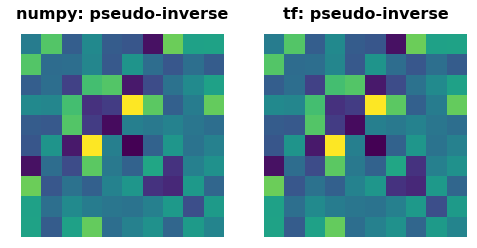

In [18]:
compare_matrices([np_inverted_matrix, inverted_matrix],["numpy: pseudo-inverse",
                                                       "tf: pseudo-inverse"])

The pseudo-inverse $A^D$ satisfies the relation

$$
AA^D = A^DA
$$

which we can check.

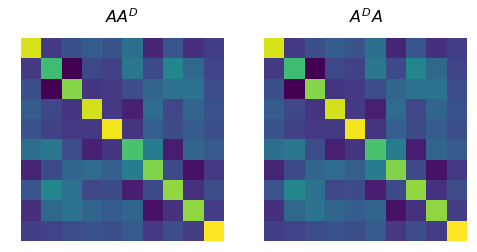

In [20]:
compare_matrices([input_matrix.dot(inverted_matrix),
                 inverted_matrix.dot(input_matrix)],[r"$AA^D$",
                                                       r"$A^DA$"])